In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial, reduce

from keras.layers import Flatten, Reshape, Input, Dense, Lambda
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.metrics import binary_crossentropy
from keras.engine.topology import Layer
from keras import optimizers
from keras import backend as K
from keras.datasets import mnist

K.set_floatx('float32')

%matplotlib inline

Using TensorFlow backend.


In [2]:
def basic_autoencoder(x_dim, y_dim, z_dim):
    K.set_image_dim_ordering('tf')
    
    input_img = Input(shape=(x_dim, y_dim, z_dim))
    x = Conv2D(16, (3,3), activation = 'relu', padding='same')(input_img)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(8, (3,3), activation = 'relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    
    x = Conv2D(8, (3,3), activation = 'relu', padding='same')(encoded)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(8, (3,3), activation = 'relu', padding='same')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(16, (3,3), activation = 'relu')(x)
    x = UpSampling2D(size=(2,2))(x)
    decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    
    rep = Model(input_img, decoded)
    rep.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return rep

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28 ,1))

In [4]:
net = basic_autoencoder(28,28,1)

In [131]:
net.fit(x_train, x_train, epochs=40, batch_size=128, shuffle=True, validation_data=(x_test, x_test), callbacks=[TensorBoard(log_dir='/tmp/ae')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
  768/60000 [..............................] - ETA: 10s - loss: 0.6838

KeyboardInterrupt: 

In [7]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [359]:
# because Keras isn't powerful to handle the loss for a CVAE
# we have to create an actual loss layer to calculate it

class CVAELossLayer(Layer):
    def __init__(self, latent_dim, image_size, **kwargs):
        self.latent_dim = latent_dim
        self.image_size = image_size
        
        self.is_placeholder = True
        
        super(CVAELossLayer, self).__init__(**kwargs)
        
    def calculate_loss(self, inputs):
        x = inputs[0]
        z_mean = inputs[1][:,:self.latent_dim]
        z_log_sigma = inputs[1][:,self.latent_dim:]
        dec_x = inputs[2]
        
        # we clip the mean here to a large number to prevent float overflow
        # which happens sometimes. 1e10 is large enough!
        output_loss = self.image_size * K.clip(K.mean(K.binary_crossentropy(K.clip(dec_x, 1e-10, 0.999), K.clip(x, 1e-10, 0.999)), axis=-1), 0, 1e10)
        # this is the Kullback Libeler divergence between the
        # distribution in latent space and the prior
        latent_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
        
        return K.mean(output_loss + latent_loss)
    
    def call(self, inputs):
        loss = self.calculate_loss(inputs)
        # this is the hacky way to calculate our loss
        # we use the inputs given to calculate the loss
        # and then return it for direct use for fitting
        return loss
    
    def compute_output_shape(self, input_shape):
        return (64, 1)

In [360]:
def dist_sample(latent_dims, inputs):
    z_mean = inputs[:,:latent_dims]
    z_log_sigma = inputs[:,latent_dims:]

    eps = K.random_normal(shape=(latent_dims,), mean=0.0, stddev=1.0, dtype='float32')
    
    return z_mean + (K.exp(z_log_sigma) * eps)

def sample_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] //= 2
    return tuple(shape)



# build encoder net
def build_encoder(shape, latent_dim, num_k=64, k_size=3, int_dim=256):
    c_params = {'padding' : 'same', 'activation' : 'relu'}
    p_params= {'pool_size' : (2,2), 'strides' : (2,2), 'padding' : 'same'}
    
    inp = Input(shape=shape)
    
    x = Conv2D(num_k, (2, 2), **c_params)(inp)
    x = MaxPooling2D(**p_params)(x)
    x = Conv2D(num_k * 2, (k_size, k_size), **c_params)(x)
    x = MaxPooling2D(**p_params)(x)
    x = Conv2D(num_k * 4, (k_size, k_size), **c_params)(x)
    x = MaxPooling2D(**p_params)(x)
    x = Conv2D(num_k * 4, (k_size, k_size), **c_params)(x)
    flat = Flatten()(x)
    d = Dense(int_dim, activation='relu')(flat)
    encoded = Dense(latent_dim * 2)(d)
    
    return Model(inp, encoded)


def build_decoder(output_shape, latent_dim, num_k=64, k_size=2):
    
    # build a layer to sample from the given probability distribution
    sample_func = partial(dist_sample, latent_dim)
    
    enc = Input(shape=(latent_dim*2,))
    
    sample = Lambda(sample_func, output_shape = sample_output_shape)(enc)
    
    x = Dense(num_k * (output_shape[0] // 2) * (output_shape[1] // 2), activation = 'relu')(sample)
    
    x = Reshape((output_shape[0] // 2, output_shape[1] // 2, num_k))(x)
    
    int_shape = (output_shape[0], output_shape[1], num_k)
    params = {'activation' : 'relu', 'padding' : 'valid'}
    p_params= {'pool_size' : (2,2), 'strides' : (2,2), 'padding' : 'same'}
    
    x = Conv2DTranspose(num_k*2, (k_size, k_size), strides=(1,1), activation = 'relu', padding='same')(x)
    x = Conv2DTranspose(num_k, (k_size, k_size), strides=(2,2), activation = 'relu', padding='valid')(x)
    x = Conv2DTranspose(num_k, (k_size, k_size), strides=(2,2), activation = 'relu', padding='valid')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = MaxPooling2D(**p_params)(x)
    decoded = Conv2D(1, (2,2), padding = 'valid', activation='sigmoid')(x)
  
    return Model(enc, decoded)

In [362]:
shape = (28,28,1)
image_size = reduce(lambda x, y: x * y, shape)
latent_dim = 10

def build_cvae(img_shape, image_size, latent_dim):
    raw_inp = Input(shape=(shape[0], shape[1], shape[2]))

    encoder = build_encoder(shape, latent_dim)
    encoded = encoder(raw_inp)

    decoder = build_decoder(shape, latent_dim)
    decoded = decoder(encoded)


    flat_raw = Flatten()(raw_inp)
    flat_decoded = Flatten()(decoded)
    loss = CVAELossLayer(latent_dim, image_size, name='cvae_loss')([flat_raw, encoded, flat_decoded])

    return Model(inputs=[raw_inp], outputs=[loss])


model = build_cvae(shape, image_size, latent_dim)

In [363]:
model.compile(optimizer='adagrad', loss={'cvae_loss' : lambda y_true, y_pred: y_pred})

In [364]:
model.fit(x_train, np.repeat(1, 60000), epochs=10, batch_size=64, shuffle=True, validation_data=(x_test, np.repeat(1,10000)), callbacks=[TensorBoard(log_dir='/tmp/ae')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 34s - loss: 273.8309 - val_loss: 136.8454

KeyboardInterrupt: 

In [ ]:
x_test[0].reshape((28,28)).shape

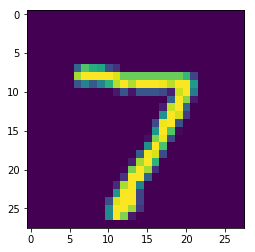

In [202]:
plt.imshow(x_test[0].reshape((28,28)))

In [203]:
pred = a_model.predict(x_test[:10], batch_size=10, verbose=0)

In [204]:
pred[0][1]

IndexError: invalid index to scalar variable.

In [342]:
e = a_model.layers[1]
d = a_model.layers[2]

In [343]:
vecs = e.predict(x_test[:10], batch_size=10, verbose=0)

In [344]:
vecs[4]

array([ -4.32653040e-01,  -4.44193870e-01,  -2.15242151e-03,
         3.96199301e-02,   9.41501856e-01,  -3.65501463e-01,
         5.00698745e-01,  -7.22876310e-01,  -5.34370601e-01,
        -1.26836050e+00,  -2.14418983e+00,  -2.56974530e+00,
        -3.09413958e+00,  -2.42485094e+00,  -2.81253648e+00,
        -2.56429839e+00,  -2.67508268e+00,  -2.74011874e+00,
        -9.70474422e-01,  -2.74544859e+00], dtype=float32)

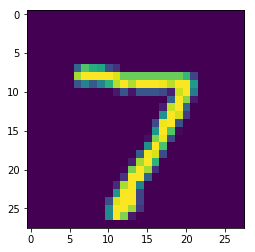

[ 0.03138364  0.077348   -0.11385111  0.18708742  0.34236351 -0.83968365
 -0.18647081  2.24620271  0.16714087 -1.00018466 -2.22895479 -2.7757144
 -2.82132864 -2.6178534  -2.90710902 -2.26576185 -3.05391598 -2.95348883
 -1.17221749 -2.85240698]


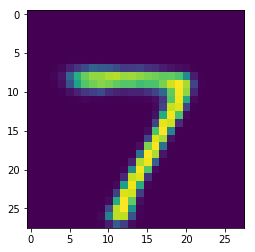

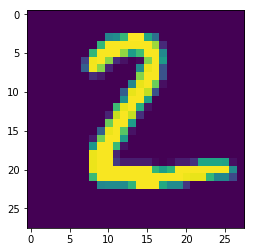

[ 0.68070722 -1.27106273 -0.94119579 -0.78582644 -0.17891394  0.86015189
  0.95696461 -0.12263143  0.14574221  1.52732933 -2.64500523 -2.68025351
 -2.47911167 -3.00071645 -3.12572742 -2.52174425 -3.05305076 -3.31043553
 -1.93472576 -2.8783412 ]


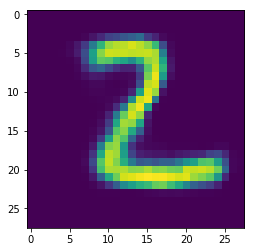

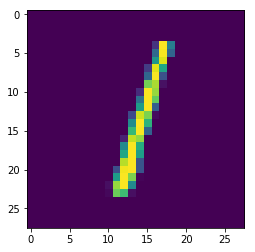

[-0.06111915 -1.1834718   0.57694101  0.78356141 -1.71953142  0.11917333
  0.24958181  0.25545916  0.00859282 -0.2968137  -2.12485623 -2.23066092
 -2.33315611 -2.00205374 -2.70102954 -1.71333694 -2.7832427  -2.59662008
 -0.83255208 -2.59489942]


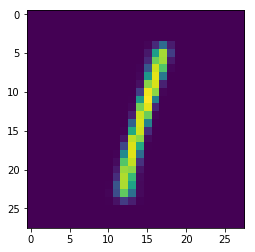

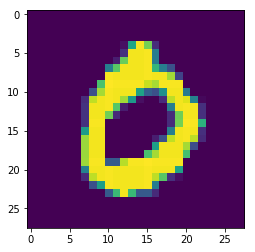

[-0.35356423  1.37201965 -0.12602921  0.09902883  0.4724628  -0.2456947
  0.07726193 -0.30190209  0.09641761  0.20395407 -2.30445719 -2.79981184
 -3.27684069 -2.71981072 -2.97190213 -2.6417172  -2.97479343 -2.88807869
 -1.14885616 -2.96646261]


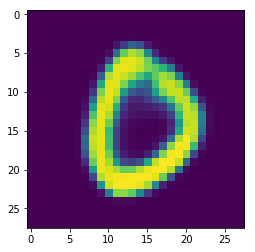

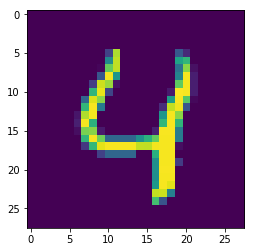

[ -4.32653040e-01  -4.44193870e-01  -2.15242151e-03   3.96199301e-02
   9.41501856e-01  -3.65501463e-01   5.00698745e-01  -7.22876310e-01
  -5.34370601e-01  -1.26836050e+00  -2.14418983e+00  -2.56974530e+00
  -3.09413958e+00  -2.42485094e+00  -2.81253648e+00  -2.56429839e+00
  -2.67508268e+00  -2.74011874e+00  -9.70474422e-01  -2.74544859e+00]


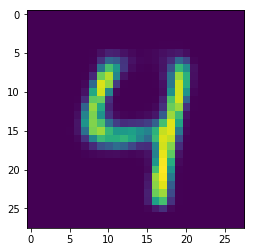

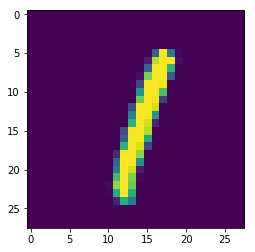

[-0.41955951 -1.03453958  1.12028027  0.38394964 -1.42638671  0.51107085
  0.16026473  0.46417084  0.01335005 -0.29245868 -2.09610653 -2.25068808
 -2.29437804 -2.10265946 -2.75688195 -1.69467759 -2.82143354 -2.462677
 -0.8401885  -2.59903359]


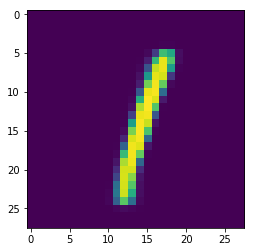

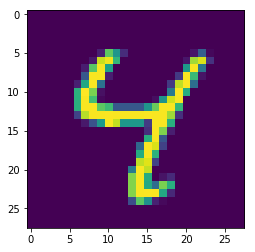

[-0.38656661 -1.06659722  0.45703009 -0.49556994  0.84140384 -0.61608684
  0.15477148  0.50534403 -0.07278798 -0.91806608 -2.08859348 -2.52104092
 -2.67087793 -2.57784748 -3.05383015 -2.32253027 -2.61456013 -2.81304002
 -1.14797938 -2.62247205]


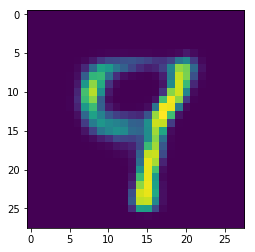

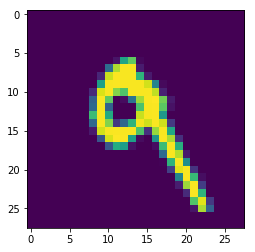

[ 0.92724389 -0.04174039 -0.41184607 -0.35592449 -0.00610303  1.34273565
  1.44192243 -0.60711718 -0.1837903  -0.82751632 -2.30996156 -2.62432098
 -2.87966847 -2.73518515 -2.71234798 -2.53244686 -2.71575928 -2.70930338
 -1.17106724 -2.80610394]


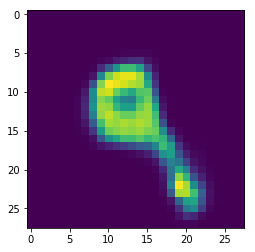

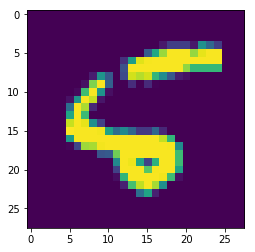

[ 0.78201348 -0.93899035  0.4392879  -0.69951379  0.89760232 -0.43362612
 -0.5693562  -0.63392252 -0.90991676  0.07354347 -2.43411112 -2.53327203
 -2.60404301 -2.59947658 -3.08718967 -2.57497787 -2.76366544 -3.15555525
 -1.75957489 -2.6018858 ]


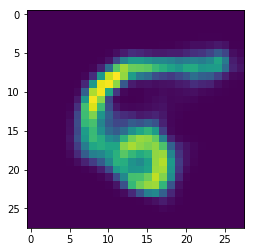

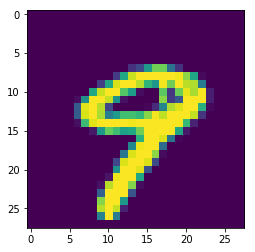

[-0.16493455  1.07371986  0.83183372 -0.22709975 -0.02795145 -0.39949182
 -0.8643859   1.05772042  0.02811697 -0.71619552 -2.21417069 -2.74409652
 -2.85385442 -2.5880785  -3.00957823 -2.3423121  -2.98141932 -2.80685616
 -1.08022571 -2.92215919]


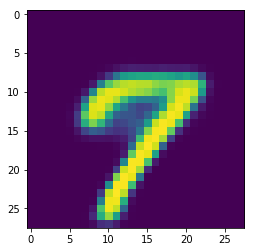

In [345]:
pred = d.predict(vecs, batch_size=10, verbose=0)

for i in range(10):
    plt.imshow(x_test[i].reshape((28,28)))
    plt.axis('on')
    plt.show()
    print(vecs[i])
    plt.imshow(pred[i].reshape((28,28)))
    plt.axis('on')
    plt.show()

In [275]:
d = model.layers[1]

In [346]:
def lel(arr):
    plt.imshow(d.predict(arr, batch_size=1,verbose=0).reshape((28,28)))

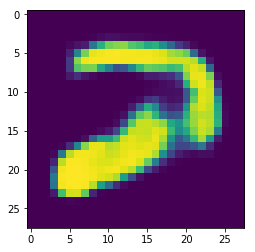

In [354]:
arr = np.random.normal(size=(1,20))
lel(arr)

In [196]:
vecs[0].size

4